In [1]:
import os

input_lang = "eng"
target_lang = "spa"

if os.path.isfile(f"{input_lang}-{target_lang}.txt"):
    filepath = f"{input_lang}-{target_lang}.txt"
    reverse = False
elif os.path.isfile(f"{target_lang}-{input_lang}.txt"):
    filepath = f"{target_lang}-{input_lang}.txt"
    reverse = True
else:
    raise FileNotFoundError("Missing training set for specified language pair")

In [2]:
import contractions, re
from torchtext.data.utils import get_tokenizer

tokenizer_eng = get_tokenizer("spacy", language="en_core_web_sm")
tokenizer_spa = get_tokenizer("spacy", language="es_core_news_sm")

def tokenize(text, lang):
    """Tokenize, standardize and filter text."""
    if lang == "eng":
        text = contractions.fix(text)
        tokenizer = tokenizer_eng
    elif lang == "spa":
        tokenizer = tokenizer_spa
    else:
        raise NotImplementedError("Missing tokenizer for specified language ")

    standardized_text = (
        text.replace("’", "'")
        .replace("‘", "'")
        .replace("´", "'")
        .replace("“", '"')
        .replace("”", '"')
        .replace("´´", '"')
    )
    tokens = tokenizer(standardized_text)
    filtered_tokens = [
        token
        for token in tokens
        if re.match(
            r"""
            ^[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿]+  # 1+ allowed characters.
            (-[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿]+)*  # Opt hyphen plus chars.
            (_[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿]+)*  # Opt underscore plus chars.
            $  # End of the string.
            """,
            token,
            re.VERBOSE,
        )
    ]
    return filtered_tokens

In [3]:
def corpus_iterator(filepath, lang, reverse):
    """Read and tokenize sentences by iterating through a corpus file."""
    with open(filepath, "r", encoding="utf-8") as file:
        for line in file:
            elems = line.strip().split("\t")
            selected_text = elems[1 if reverse else 0]
            yield tokenize(selected_text, lang)

In [4]:
from torchtext.vocab import build_vocab_from_iterator

def build_vocab(filepath, lang, reverse, min_freq=5, specials="<unk>"):
    """Build vocabulary."""
    vocab = build_vocab_from_iterator(
        corpus_iterator(filepath, lang, reverse),
        min_freq=min_freq,
        specials=specials,
    )
    vocab.set_default_index(vocab[specials[-1]])
    return vocab

special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]

vocab_input = build_vocab(filepath, input_lang, reverse, specials=special_tokens)
vocab_target = build_vocab(filepath, target_lang, not reverse, specials=special_tokens)

In [5]:
special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
vocab_input = build_vocab(filepath, input_lang, reverse, specials=special_tokens)
vocab_target = build_vocab(filepath, target_lang, not reverse, specials=special_tokens)

In [6]:
import numpy as np

def all_words_in_vocab(sentence, vocab):
    """Check whether all words in a sentence are present in a vocabulary."""
    return all(word in vocab for word in sentence)

def pad_sentence(sequence, max_length=10):
    """Pad sentence."""
    padding_length = max_length - len(sequence)
    return ["<sos>"] + sequence + ["<eos>"] + ["<pad>"] * padding_length

def process_corpus(lines, reverse, input_lang, target_lang, vocab_input,
                   vocab_target, max_length=10):
    """."""
    processed_inputs, processed_targets = [], []
    for line in lines:
        elems = line.strip().split("\t")

        input_seq = tokenize(elems[int(reverse)], input_lang)
        target_seq = tokenize(elems[int(not reverse)], target_lang)

        if (all_words_in_vocab(input_seq, vocab_input)
            and all_words_in_vocab(target_seq, vocab_target)
            and len(input_seq) <= max_length
            and len(target_seq) <= max_length):
            padded_input = pad_sentence(input_seq)
            padded_target = pad_sentence(target_seq)

            processed_inputs.append(vocab_input(padded_input))
            processed_targets.append(vocab_target(padded_target))

    return np.array(processed_inputs), np.array(processed_targets)

In [7]:
import deeptrack as dt
import torch
from torch.utils.data import DataLoader

with open(filepath, "r", encoding="utf-8") as file:
    inputs, targets = process_corpus(
        file, reverse, input_lang, target_lang, vocab_input, vocab_target,
    )

sources = dt.sources.Source(inputs=inputs, targets=targets)
train_sources, test_sources = dt.sources.random_split(sources, [0.85, 0.15])

inputs_pl = dt.Value(sources.inputs) >> dt.pytorch.ToTensor(dtype=torch.int)
targets_pl = dt.Value(sources.targets) >> dt.pytorch.ToTensor(dtype=torch.int)

train_dataset = dt.pytorch.Dataset(
    inputs_pl & targets_pl,
    inputs=train_sources,
)
test_dataset = dt.pytorch.Dataset(
    inputs_pl & targets_pl, 
    inputs=test_sources,
)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [8]:
import deeplay as dl
import torch

class Seq2SeqEncoder(dl.DeeplayModule):
    """Seq2seq encoder."""

    def __init__(self, vocab_size, in_features=300, hidden_features=128,
                 hidden_layers=1, dropout= 0.0, rnn_type="GRU",
                 bidirectional=True):
        """Initialize seq2seq encoder."""
        super().__init__()
        if isinstance(rnn_type, type) and issubclass(rnn_type, torch.nn.Module):
            self.rnn_class = rnn_type
        elif rnn_type == "LSTM":
            self.rnn_class = torch.nn.LSTM
        elif rnn_type == "GRU":
            self.rnn_class = torch.nn.GRU
        else:
            self.rnn_class = torch.nn.RNN

        self.hidden_features = hidden_features
        self.hidden_layers = hidden_layers
        self.bidirectional = bidirectional
        self.embedding = dl.Layer(torch.nn.Embedding, vocab_size, in_features)
        self.rnn = dl.Layer(
            self.rnn_class,
            input_size=in_features,
            hidden_size=hidden_features,
            num_layers=hidden_layers,
            dropout=(0 if hidden_layers == 1 else dropout),
            bidirectional=bidirectional,
            batch_first=True,
        )

    def forward(self, x, hidden=None):
        """Perform forward pass."""
        x = self.embedding(x)
        outputs, hidden = self.rnn(x, hidden)
        if self.bidirectional:
            outputs = (
                outputs[:, :, :self.hidden_features]
                + outputs[:, :, self.hidden_features:]
            )
            hidden = hidden[: self.hidden_layers]
        return outputs, hidden

In [9]:
class Seq2SeqDecoder(dl.DeeplayModule):
    """Seq2seq decoder."""

    def __init__(self, vocab_size, in_features=300, 
                 hidden_features=128, hidden_layers=1, dropout=0.0, 
                 rnn_type="GRU"):
        """Initialize seq2seq decoder."""
        super().__init__()
        if isinstance(rnn_type, type) and issubclass(rnn_type, torch.nn.Module):
            self.rnn_class = rnn_type
        elif rnn_type == "LSTM":
            self.rnn_class = torch.nn.LSTM
        elif rnn_type == "GRU":
            self.rnn_class = torch.nn.GRU
        else:
            self.rnn_class = torch.nn.RNN

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_layers = hidden_layers
        self.embedding = dl.Layer(torch.nn.Embedding, vocab_size, in_features)
        self.rnn = dl.Layer(
            self.rnn_class,
            input_size=in_features,
            hidden_size=hidden_features,
            num_layers=hidden_layers,
            bidirectional=False,
            batch_first=True,
            dropout=(0 if hidden_layers == 1 else dropout),
        )
        self.dense = dl.Layer(torch.nn.Linear, hidden_features, vocab_size)
        self.softmax = dl.Layer(torch.nn.Softmax, dim=-1)
        self.relu = dl.Layer(torch.nn.ReLU)

    def forward(self, x, hidden):
        """Perform forward pass."""
        x = self.embedding(x)
        x = self.relu(x)
        output, hidden = self.rnn(x, hidden)
        output = self.dense(output)
        output = self.softmax(output)
        return output, hidden

In [10]:
class Seq2SeqModel(dl.DeeplayModule):
    """Seq2seq model."""

    def __init__(self, in_vocab_size=None, out_vocab_size=None,
                 teacher_prob=1.0, embedding_dim=300, hidden_features=128,
                 hidden_layers=1, dropout=0.0, rnn_type="GRU",
                 bidirectional=True):
        """Initialize the seq2seq model."""
        super().__init__()
        self.out_vocab_size = out_vocab_size
        self.teacher_prob = teacher_prob
        self.encoder = \
            Seq2SeqEncoder(in_vocab_size, embedding_dim, hidden_features,
                           hidden_layers, dropout, rnn_type, bidirectional)
        self.decoder = \
            Seq2SeqDecoder(out_vocab_size, embedding_dim, hidden_features,
                           hidden_layers, dropout, rnn_type)

    def forward(self, x):
        """Perform forward pass."""
        input, target = x
        
        encoder_outputs, encoder_hidden = self.encoder(input)
        
        decoder_hidden = encoder_hidden
        decoder_outputs = torch.zeros(
            (target.size(0), target.size(1), self.out_vocab_size)
        ).to(next(self.encoder.parameters()).device)

        for t in range(input.size(1)):
            if t == 0 or np.random.rand() < self.teacher_prob:
                decoder_input = target[:, t].unsqueeze(-1)
            else:
                decoder_input = topi.squeeze(-1).detach()

            decoder_input = \
                decoder_input.to(next(self.decoder.parameters()).device)
            decoder_output, decoder_hidden = \
                self.decoder(decoder_input, decoder_hidden)
            _, topi = decoder_output.topk(1)
            decoder_outputs[:, t, :] = decoder_output.squeeze(1)
        return decoder_outputs

    def evaluate(self, x):
        """Evaluate model."""
        if isinstance(x, (list, tuple)):
            input = x[0]
        else:
            input = x

        with torch.no_grad():
            encoder_outputs, encoder_hidden = self.encoder(input)
        decoder_hidden = encoder_hidden
        outputs = torch.zeros(
            input.shape,
        ).to(next(self.encoder.parameters()).device)
        for t in range(input.size(1)):
            if t == 0:
                decoder_input = torch.full(
                    size=(input.size(0), 1),
                    fill_value=1,
                    device=next(self.encoder.parameters()).device,
                )
            else:
                decoder_input = topi.squeeze(-1).detach()

            decoder_input = decoder_input.to(next(self.decoder.parameters()).device)
            with torch.no_grad():
                decoder_output, decoder_hidden = self.decoder(
                    decoder_input,
                    decoder_hidden,
                )
            _, topi = decoder_output.topk(1)
            outputs[:, t] = topi.squeeze()

        return outputs

In [11]:
def maskedNLL(input, target, PADtoken=0):
    """Calculate the negative log-likelihood loss."""
    mask = target != PADtoken
    NLL = - torch.log(
        torch.gather(input.view(-1, input.shape[-1]), 1, target.view(-1, 1))
    )
    loss = NLL.masked_select(mask.view(-1, 1)).mean()
    return loss


In [12]:
class Seq2Seq(dl.Application):
    """Application for the seq2seq model."""

    def __init__(self, in_vocab, out_vocab, teacher_prob=1.0, model=None,
                 optimizer=None, loss=None):
        """Initialize the application."""
        self.in_vocab = in_vocab
        self.in_vocab_size = len(in_vocab)
        self.out_vocab = out_vocab
        self.out_vocab_size = len(out_vocab)
        self.teacher_prob = teacher_prob
        self.model = model or Seq2SeqModel(
            in_vocab_size=self.in_vocab_size,
            out_vocab_size=self.out_vocab_size,
            teacher_prob=teacher_prob,
        )
        self.optimizer = optimizer or dl.Adam(lr=1e-3)
        self.loss = loss or maskedNLL

        @self.optimizer.params
        def params(self):
            return self.parameters()

        super().__init__(loss=loss)

    def train_preprocess(self, batch):
        """Adjust the target sequence by shifting it one position backward."""
        x = batch
        y = torch.cat((x[-1][:, 1:], x[-1][:, -1:]), dim=1)
        return x, y

    def forward(self, x):
        """Perform forward pass."""
        decoder_outputs = self.model(x)
        return decoder_outputs

In [13]:
from torchtext.vocab import GloVe

embedding_dim = 300

glove = GloVe(name="42B", dim=embedding_dim, cache="./.vector_cache")
glove_embeddings_input = \
    glove.get_vecs_by_tokens(vocab_input.get_itos(), lower_case_backup=True)
glove_embeddings_target = \
    glove.get_vecs_by_tokens(vocab_target.get_itos(), lower_case_backup=True)

num_special_tokens = len(special_tokens)
glove_embeddings_input[1:num_special_tokens] = \
    torch.rand(num_special_tokens - 1, embedding_dim) * 0.01
glove_embeddings_target[1:num_special_tokens] = \
    torch.rand(num_special_tokens - 1, embedding_dim) * 0.01


INFO:torchtext.vocab.vectors:Loading vectors from ./.vector_cache/glove.42B.300d.txt.pt


In [14]:
seq2seq = Seq2Seq(
    in_vocab=vocab_input,
    out_vocab=vocab_target,
    teacher_prob=0.85,
)
seq2seq = seq2seq.create()

seq2seq.model.encoder.embedding.weight.data = glove_embeddings_input
seq2seq.model.encoder.embedding.weight.requires_grad = False
seq2seq.model.decoder.embedding.weight.data = glove_embeddings_target
seq2seq.model.decoder.embedding.weight.requires_grad = False

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ in_vocab      │ Vocab            │      0 │
│ 1 │ out_vocab     │ Vocab            │      0 │
│ 2 │ model         │ Seq2SeqModel     │  5.9 M │
│ 3 │ train_metrics │ MetricCollection │      0 │
│ 4 │ val_metrics   │ MetricCollection │      0 │
│ 5 │ test_metrics  │ MetricCollection │      0 │
│ 6 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 1.3 M                                                                                            
Non-trainable params: 4.6 M                                                                                        
Total params: 5.9 M                                                                                                
Total estimated model params size (MB): 23

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


(<Figure size 1500x500 with 1 Axes>,
 array([[<Axes: title={'center': 'Loss'}, xlabel='Step'>]], dtype=object))

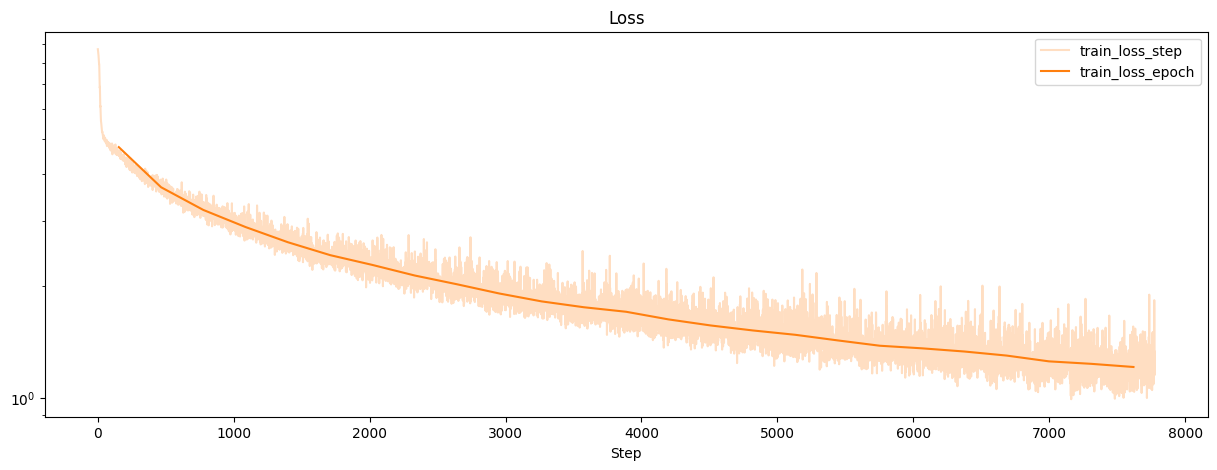

In [15]:
trainer = dl.Trainer(max_epochs=25, accelerator="auto")
trainer.fit(seq2seq, train_loader)
trainer.history.plot()

In [16]:
def unprocess(sequences, vocab):
    """Convert numeric sequences to sentences."""
    sentences = []
    for sequence in sequences:
        idxs = sequence[sequence > 2]
        words = [vocab.lookup_token(idx) for idx in idxs]
        sentences.append(" ".join(words))
    return sentences


In [17]:
def translate(source_text, model, input_lang, vocab_input, vocab_target):
    """Translate sentences."""
    query_tokens = tokenize(source_text, input_lang)
    query_tokens = pad_sentence(query_tokens)
    query_indices = vocab_input(query_tokens)
    if 3 in query_indices:
        print("Warning: Unknown word(s) found in the input text. "
              + "They were replaced by the placeholder token.")

    source_sequence = torch.tensor(query_indices, dtype=torch.int).unsqueeze(0)

    source_sequence = source_sequence.to(next(model.parameters()).device)
    y_hat = model.evaluate(source_sequence)

    translated_text = unprocess(y_hat, vocab_target)
    print(f"Input Sentence: {source_text}")
    print(f"Predicted Translation: {translated_text[0]}\n")

In [18]:
source_text = "Do you think that we should go home?"
translate(source_text, seq2seq.model, input_lang, vocab_input, vocab_target)

Input Sentence: Do you think that we should go home?
Predicted Translation: I usually make me angry .



In [19]:
source_text = "The book that I bought is very interesting."
translate(source_text, seq2seq.model, input_lang, vocab_input, vocab_target)

Input Sentence: The book that I bought is very interesting.
Predicted Translation: I tried to help me , but I ate .



In [20]:
from torchmetrics.text import BLEUScore

bleu_score = BLEUScore()

In [21]:
device = next(seq2seq.model.parameters()).device

for batch_index, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    y_hat = seq2seq.model.evaluate((inputs, targets))

    input_un = unprocess(inputs, vocab_input)
    y_hat_un = unprocess(y_hat, vocab_target)
    target_un = unprocess(targets, vocab_target)
    y = [[yi] for yi in target_un]

    bleu_score.update(y_hat_un, y)

    if batch_index < 3:
        print(f"\nExamples from batch {batch_index + 1}:")
        for i in range(min(3, len(input_un))):
            print(f"\nInput Sentence: {input_un[i]}")
            print(f"Predicted Translation: {y_hat_un[i]}")
            print(f"Actual Translation: {target_un[i]}")

final_bleu = bleu_score.compute()
print(f"\nValidation BLEU Score: {final_bleu:.3f}")


Examples from batch 1:

Input Sentence: Tom admitió que había cometido el homicidio .
Predicted Translation: Tom thought that he had been the murder .
Actual Translation: Tom admitted that he had committed the murder .

Input Sentence: Él habría tenido éxito .
Predicted Translation: He had been unsuccessful .
Actual Translation: He would have succeeded .

Input Sentence: Todavía tienes tiempo suficiente .
Predicted Translation: still enough .
Actual Translation: You still have enough time .

Examples from batch 2:

Input Sentence: ¡ No duele tanto !
Predicted Translation: She is very afraid .
Actual Translation: It hurt so much .

Input Sentence: ¿ Tom es tu sobrino ?
Predicted Translation: Is Tom your your ?
Actual Translation: Is Tom your nephew ?

Input Sentence: ¿ Cómo se llevan por estos días ?
Predicted Translation: How much of this makes days ?
Actual Translation: How are you getting along these days ?

Examples from batch 3:

Input Sentence: ¿ De quién es esta letra ?
Predicte